TP 2 : Lire des descripteurs
=======

1 - Introduction 
------

L'objectif de ce TP est de classer une base d'images contenant 10 catégories d'objets. Il sera à réaliser en python 3. Les librairies utilisées sont installées sur les machines de l'université, vous pouvez néanmoins les installer sur vos propres machines à l'aide de l'utilitaire pip présent par défaut avec python.
	
N'hésitez pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

- Python 3: https://docs.python.org/3/
- Numpy: https://docs.scipy.org/doc/numpy/reference/
- Scipy: https://docs.scipy.org/doc/scipy/reference/
- Matplotilb: https://matplotlib.org/contents.html
- Scikit-learn: http://scikit-learn.org

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure

from sklearn import svm
from sklearn.metrics import roc_curve, auc

La base d'image que vous étudierez est la base CIFAR-10 ( https://www.cs.toronto.edu/~kriz/cifar.html ). Vous pouvez la télécharger sur la page web de la base de données. Si vous n'avez pas installé la bibliothèque cPickle, privilégié les fichiers Matlab. 

La base CIFAR-10 contient 10 000 images d'entrainement et 10 000 images de test. Vous disposez de cinq ensembles d'entrainement différent afin de pouvoir mesurer l'impacte de l'ensemble d'apprentissage sur les performances du classifieur, vous pourrez ainsi calculer un écart-type sur votre mesure de performance. 

Pour chacun des ensembles vous disposez d'environ 1 000 images par classes (avion, voiture, oiseau, chat, cerf, chien, grenouille, cheval, bateau et camion). Chaque image est de taille 32x32 pixels en couleur. 

![Image Absente](cifar.jpg)


2 - Extraction des images de la base et calcul d'un descripteur
--------

### 2.1 - Lecture de la base de donnée

Après avoir téléchargé les fichiers de la base de données, importez les dans python. En fonction des fichiers que vous avez téléchargés, vous pouvez les lires avec l'un des deux codes suivant:

In [3]:
# Lecture des fichiers python: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

fichier_data = unpickle('cifar-10-batches-py/data_batch_1')
X_train = fichier_data[b'data']
y_train = np.array(fichier_data[b'labels'])
print('Dimension de X_train:',X_train.shape,'\nDimension de y_train:',y_train.shape)

Dimension de X_train: (10000, 3072) 
Dimension de y_train: (10000,)


La variable `y_train` contient les labels de chaque image. C'est une valeur entre 0 et 9 indiquant dans le type d'objet présent dans l'image. Vous pouvez ainsi accéder au label de l'image 9 en écrivant: 

In [5]:
print('Labels de l image 10:',y_train[9])

Labels de l image 10: 3


Que font les lignes suivantes ? : 

In [6]:
print('1- ',y_train.shape)
print('2- ',y_train.min())
print('3- ',y_train.max())
print('4- ',(y_train==1).sum())
print('5- ',np.mean(y_train>1))

1-  (10000,)
2-  0
3-  9
4-  974
5-  0.8021


La matrice `X_train` contient sur chaque ligne les pixels d'une image. Les pixels sont mis les un à la suite les un des autres. Ils correspondent à trois valeurs (rouge, vert, bleu). Ainsi une image est décrite par un vecteur de taille 3x32x32. Vous utiliserez pour cela les fonctions `np.reshape` (https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html ) et `np.transpose` (https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html ) avec des paramétres bien choisies.  

Affichez la première image de la base d'apprentissage. 

In [9]:
img = X_train[1,:]

In [13]:
img = img.reshape(3,32,32)

In [14]:
img

array([[[154, 126, 105, ...,  91,  87,  79],
        [140, 145, 125, ...,  96,  77,  71],
        [140, 139, 115, ...,  79,  68,  67],
        ...,
        [175, 156, 154, ...,  42,  61,  93],
        [165, 156, 159, ..., 103, 123, 131],
        [163, 158, 163, ..., 143, 143, 143]],

       [[177, 137, 104, ...,  95,  90,  81],
        [160, 153, 125, ...,  99,  80,  73],
        [155, 146, 115, ...,  82,  70,  69],
        ...,
        [167, 154, 160, ...,  34,  53,  83],
        [154, 152, 161, ...,  93, 114, 121],
        [148, 148, 156, ..., 133, 134, 133]],

       [[187, 136,  95, ...,  71,  71,  70],
        [169, 154, 118, ...,  78,  62,  61],
        [164, 149, 112, ...,  64,  55,  55],
        ...,
        [166, 160, 170, ...,  36,  57,  91],
        [128, 130, 142, ...,  96, 120, 131],
        [120, 122, 133, ..., 139, 142, 144]]], dtype=uint8)

In [15]:
img2 = np.transpose(img,(1,2,0))

In [19]:
img[0]
img[1]

array([[177, 137, 104, ...,  95,  90,  81],
       [160, 153, 125, ...,  99,  80,  73],
       [155, 146, 115, ...,  82,  70,  69],
       ...,
       [167, 154, 160, ...,  34,  53,  83],
       [154, 152, 161, ...,  93, 114, 121],
       [148, 148, 156, ..., 133, 134, 133]], dtype=uint8)

In [17]:
img2[0]

array([[154, 177, 187],
       [126, 137, 136],
       [105, 104,  95],
       [102, 101,  99],
       [125, 131, 139],
       [155, 166, 180],
       [172, 190, 210],
       [180, 199, 214],
       [142, 156, 156],
       [111, 120, 110],
       [106, 107,  98],
       [109, 104, 102],
       [123, 121, 117],
       [127, 129, 127],
       [181, 188, 189],
       [217, 226, 229],
       [209, 211, 211],
       [166, 167, 162],
       [164, 165, 156],
       [158, 160, 148],
       [116, 117, 103],
       [102, 101,  83],
       [ 95,  95,  76],
       [ 90,  89,  79],
       [ 72,  70,  69],
       [ 60,  60,  61],
       [ 56,  57,  54],
       [ 77,  78,  72],
       [ 94,  96,  84],
       [ 91,  95,  71],
       [ 87,  90,  71],
       [ 79,  81,  70]], dtype=uint8)

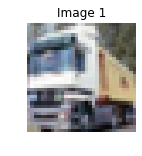

In [8]:
img = X_train[1,:]
img = img.reshape(3,32,32)
img = np.transpose(img,(1,2,0))
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.title('Image 1')
plt.show()

Affichez l'image d'indice 4 à l'écran, qu'elle est l'objet sur cette image ? Affichez le label de cette image, correspond-t-il à la catégorie que vous avez identifiée ?

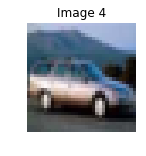

Label de l image 4: 1


In [7]:
img = X_train[4,:]
img = img.reshape(3,32,32)
img = np.transpose(img,(1,2,0))
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.title('Image 4')
plt.show()
print('Label de l image 4:',y_train[4])

Testez les commandes suivantes et expliquez leurs effets:

In [8]:
X_train2 = X_train[y_train==0,:]
y_train2 = (y_train==0).astype(int)
print('Dimension de X_train2:',X_train2.shape,'\nDimension de y_train2',y_train2.shape)

Dimension de X_train2: (1005, 3072) 
Dimension de y_train2 (10000,)


Afin de réduire le temps de calcul, vous pourrez dans la suite du tp, travailler uniquement avec les images de la classe 0 et 1 (les avions et les voitures). Chargez le premier ensemble d'apprentissage (`data_batch_1`) et l'ensemble de test (`test_batch`) et gardez uniquement les images de la classe 0 et 1. 

In [9]:
fichier_data = mio.loadmat('cifar-10-batches-mat/data_batch_1.mat')
X_train = fichier_data['data']
y_train = fichier_data['labels'][:,0]

fichier_data = mio.loadmat('cifar-10-batches-mat/test_batch.mat')
X_test = fichier_data['data']
y_test = fichier_data['labels'][:,0]

X_train = X_train[y_train<2]
y_train = y_train[y_train<2]

X_test = X_test[y_test<2]
y_test = y_test[y_test<2]

In [10]:
print('Vérification des dimensions:',X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Vérification des dimensions: (1979, 3072) (1979,) (2000, 3072) (2000,)


3 - Création du descripteur
---

Nous allons décrire chaque image à l'aide d'un descripteur HOG (http://fr.wikipedia.org/wiki/Histogramme_de_gradient_orient%C3%A9 ).

Testez l'exemple fournis par la documentation de scikit-image: 

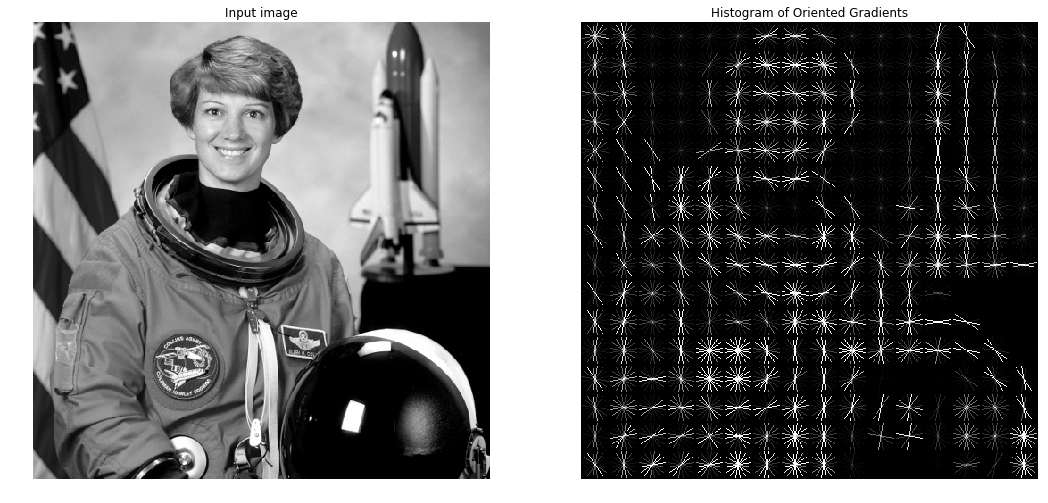

In [52]:
image = color.rgb2gray(data.astronaut())

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1),block_norm='L2', visualize=True)

plt.figure(figsize=(18, 14))

plt.subplot(121).set_axis_off()
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

plt.subplot(122).set_axis_off()
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients')
plt.show()

Le vecteur qui nous intéresse est la variable `fd` du code précédent. Nous allons représenter chaque image à l'aide de ce vecteur. 

Écrivez le code permettant de créer une matrice où chaque ligne correspond au HOG des images. Vous pourrez changer la valeur du paramètre `pixels_per_cell`  par `(4,4)` pour obtenir des résultats plus précis. Vous pouvez désactiver l'affichage pour accélérer les calculs (`visualize= False`).

Vous construirez une matrice différente pour l’entraînement (`descr_train`) et le test (`descr_test`). Afin d'optimiser au mieux votre code vous utiliserez le moins de boucle for possible. Il n'est pas nécessaire d'avoir plus d'une boucle pour construire ces matrices.

In [53]:
#HOG
#size_cell=16
size_cell=4
desc_train=[]
for i in range(X_train.shape[0]):
    im = X_train[i,:]
    im = im.reshape(3,32,32)
    im = np.transpose(im,(1,2,0))
    im = color.rgb2gray(im)
    fd = hog(im,orientations=8,pixels_per_cell=(size_cell,size_cell), cells_per_block=(1,1),block_norm='L2', visualize= False)
    desc_train.append(fd)

desc_train = np.array(desc_train)

desc_test=[]
for i in range(X_test.shape[0]):
    im = X_test[i,:]
    im = im.reshape(3,32,32)
    im = np.transpose(im,(1,2,0))
    im = color.rgb2gray(im)
    fd = hog(im,orientations=8,pixels_per_cell=(size_cell,size_cell), cells_per_block=(1,1),block_norm='L2', visualize= False)
    desc_test.append(fd)
    
desc_test = np.array(desc_test)

In [54]:
print('Vérification des dimensions:',desc_train.shape,desc_test.shape)

Vérification des dimensions: (1979, 512) (2000, 512)


4 - Classification
----

Faites un détecteur d'avion en utilisant le descripteur précédent. Vous utiliserez pour cela un classifieur de type SVM. 

In [55]:
%time
svc = svm.SVC().fit(desc_train,y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


Affichez le score de classification à l'aide d'une courbe ROC. Vous pouvez vous inspirer du code suivant:  

Area under the ROC curve : 0.933044


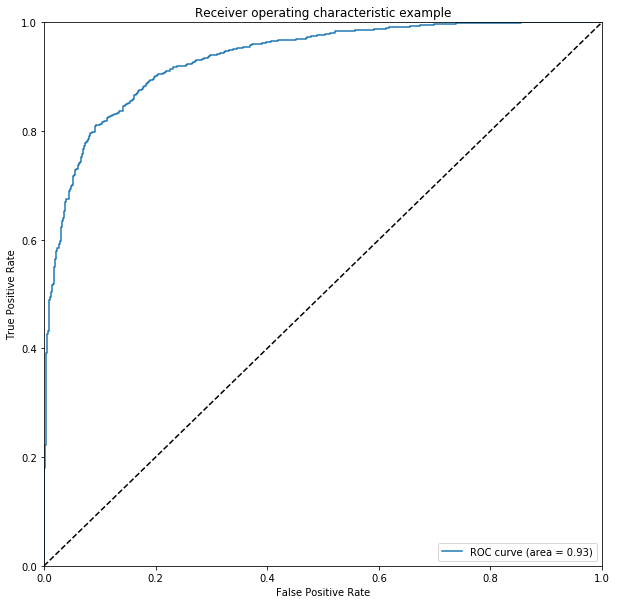

In [56]:
Z = svc.decision_function(desc_test)
fpr, tpr, thresholds = roc_curve(y_test, Z)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)
# Plot ROC curve
plt.figure(figsize=(10,10))
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Expliquez vos résultats, à quoi correspond la courbe ROC ? Que représente l'aire sous cette courbe ? Votre classifieur est-il bon ? 

Réalisez maintenant vos tests avec toutes les  classes et tous les ensembles d'apprentissages. Quelles sont vos performances ?  Y-a-t-il des classes plus difficile que d'autre ? Des noyaux plus performants que d'autre ? 